In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
DATA_PATH = "/kaggle/input/playground-series-s4e5/"

In [3]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# EDA

In [12]:
df = pl.read_csv(os.path.join(DATA_PATH, "train.csv"))
df.head(5)

id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64
0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.45
2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.53
3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


In [14]:
# null values
(df
 .select(pl.all().is_null().sum()).rename(lambda x:x+"_null_values")
 .select(sum([pl.col(col+"_null_values") for col in df.columns]).alias("Total_null_values"))
)

Total_null_values
i64
0


In [ ]:
# distribution of the data
fig, axes = plt.subplots(10, 2, figsize=(10, 20))
idx, i, j = 0, 0, 0
for col in df.columns[1:-1]:
    df.select(pl.col(col)).to_pandas().plot(kind='hist', density=True, edgecolor='black', ax=axes[i][j])
    idx += 1
    j = 1*(idx % 2 != 0)
    i = idx // 2

In [ ]:
# correlations
sns.heatmap(df
            .corr()
            .select(pl.Series(df.columns).alias("index"), pl.all())
            .to_pandas()
            .set_index("index")
           )
# all features seems to have exactly the same correlation with label

In [17]:
X = df.select(pl.all().exclude("id", "FloodProbability")).to_numpy()
y = df.select(pl.col("FloodProbability")).to_numpy().reshape(-1, )

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [16]:
from sklearn.metrics import r2_score, mean_squared_error
def evaluate_model(model_name, model, train_data, validation_data, is_xgb:bool=False):

    if is_xgb:
        y_pred = model.predict( xgb.DMatrix(train_data[0]) )
        y_pred_val = model.predict( xgb.DMatrix(validation_data[0]) )
    else:
        y_pred = model.predict(train_data[0])
        y_pred_val = model.predict(validation_data[0])

    train =  [r2_score(train_data[1], y_pred),
              np.round(np.sqrt(mean_squared_error(train_data[1], y_pred)), 4),
              np.round(np.sqrt(mean_squared_error(train_data[1], y_pred))*100/train_data[1].mean(), 2),
    ]
    
    val = [r2_score(validation_data[1], y_pred_val),
           np.round(np.sqrt(mean_squared_error(validation_data[1], y_pred_val)), 4),
           np.round(np.sqrt(mean_squared_error(validation_data[1], y_pred_val))*100/validation_data[1].mean(), 2)
    ]
    
    return pd.DataFrame({
        "Score": ["r2_score", "rmse", "rmse_percent"],
        "Train": train,
        "Validation": val
    })

In [20]:
# Feature Transformation
from sklearn.preprocessing import FunctionTransformer

# def func(x):
#     return np.log1p(x)

log_transformer = FunctionTransformer(np.log1p)
X_train_log = log_transformer.transform(X_train)
X_val_log = log_transformer.transform(X_val)

In [25]:
# Linear Regression

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
evaluate_model("lin_reg", lin_reg, (X_train, y_train), (X_val, y_val))

,Score,Train,Validation
0,r2_score,0.844997,0.84476
1,rmse,0.020100,0.02010
2,rmse_percent,3.980000,3.99000


In [26]:
# Linear Regression on transformed features
lin_reg.fit(X_train_log, y_train)
evaluate_model("lin_reg", lin_reg, (X_train_log, y_train), (X_val_log, y_val))

,Score,Train,Validation
0,r2_score,0.756964,0.757238
1,rmse,0.025200,0.025100
2,rmse_percent,4.990000,4.980000


In [28]:
# XGBoost

import xgboost as xgb
dmatrix_train = xgb.DMatrix(X_train, y_train)
dmatrix_val = xgb.DMatrix(X_val, y_val)

params = {
    "objective": "reg:squarederror",
    "booster": "gbtree",
    "eval_metric": ["rmse"],
    "eta": 0.2,
    "max_depth": 10,
}
num_trees=200

training_results = {}

model = xgb.train(
    params,
    dmatrix_train,
    num_trees,
    evals=[(dmatrix_train, "train"), (dmatrix_val, "validation")],
    evals_result = training_results,
    verbose_eval=False,
    early_stopping_rounds=10
)

Text(0, 0.5, 'rmse')

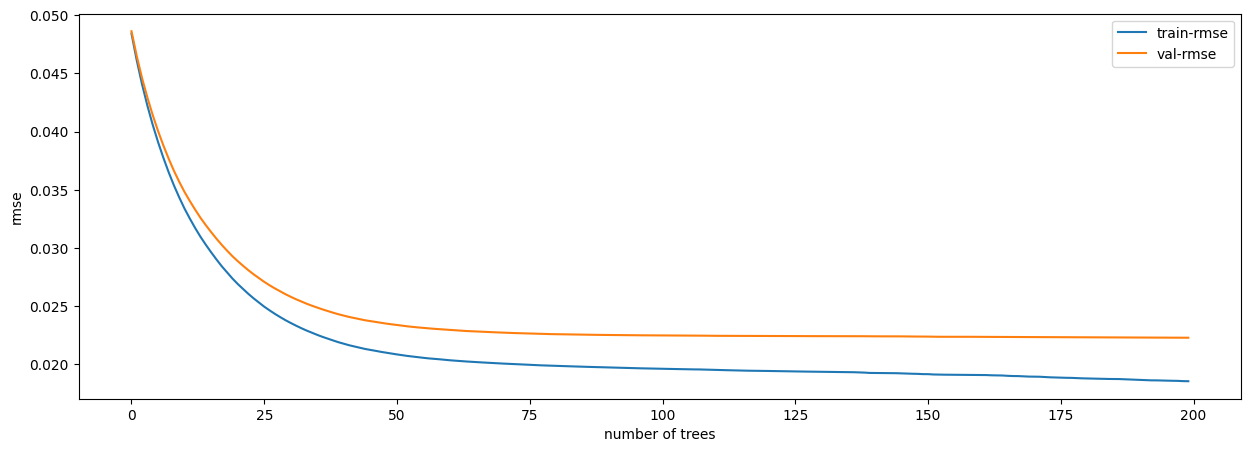

In [29]:
# plot of loss function vs number of boosting rounds
n_tr = len(training_results['train']['rmse'])
plt.figure(figsize=(15, 5))
plt.plot(range(n_tr), training_results['train']['rmse'], label="train-rmse")
plt.plot(range(n_tr), training_results['validation']['rmse'], label="val-rmse")
plt.legend()
plt.xlabel("number of trees")
plt.ylabel("rmse")

In [30]:
#evaluate xgboost
evaluate_model("xgb", model, (X_train, y_train), (X_val, y_val), True)

,Score,Train,Validation
0,r2_score,0.867701,0.809162
1,rmse,0.018600,0.022300
2,rmse_percent,3.680000,4.420000


In [31]:
# xgboost on transformed features

dmatrix_train = xgb.DMatrix(X_train_log, y_train)
dmatrix_val = xgb.DMatrix(X_val_log, y_val)

params = {
    "objective": "reg:squarederror",
    "booster": "gbtree",
    "eval_metric": ["rmse"],
    "eta": 0.2,
    "max_depth": 10,
}
num_trees=200

training_results = {}

model = xgb.train(
    params,
    dmatrix_train,
    num_trees,
    evals=[(dmatrix_train, "train"), (dmatrix_val, "validation")],
    evals_result = training_results,
    verbose_eval=False,
    early_stopping_rounds=10,
)

evaluate_model("xgb", model, (X_train_log, y_train), (X_val_log, y_val), True)

,Score,Train,Validation
0,r2_score,0.867701,0.809162
1,rmse,0.018600,0.022300
2,rmse_percent,3.680000,4.420000


In [ ]:
# Results of XGBoost are same on both original data and transformed data, therefore
# we're going to proceed with the transformed data

# Hyperparameter Tuning of XGBoost

In [33]:
import optuna

In [40]:
dmatrix_train = xgb.DMatrix(X_train, y_train)
dmatrix_val = xgb.DMatrix(X_val_log, y_val)

def objective(trial):
  param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": ["rmse"],
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear"]),
        "lambda": trial.suggest_float("lambda", 2, 3),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
#         "device": "cuda"
    }

  if param["booster"] in ["gbtree"]:
      param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
      param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
      param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
      param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
      param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

  model=xgb.train(
    params=param,
    dtrain=dmatrix_train,
    evals=[(dmatrix_train, "train"), (dmatrix_val, "validation")],
    num_boost_round=trial.suggest_int('n_estimators', 40, 140),
    early_stopping_rounds=10,
  )

  pred = model.predict(xgb.DMatrix(X_val))
  rmse = np.sqrt(mean_squared_error(y_val, pred))

  return rmse

In [ ]:
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=150)

In [ ]:
# print(best_trail.value)
# print(best_trail.params)

# Ensemble - Stacking

In [41]:
from sklearn.model_selection import KFold
skf = KFold(n_splits=5, shuffle=True, random_state=42)

splits = []
for i, (train_idx, val_idx) in enumerate(skf.split(X_train_log, y_train)):
  splits.append([train_idx, val_idx])

In [42]:
# -------Architecture of the Ensemble-------
#     
#               XGBoost Model (xgb_1) --------
#                                             |----XGBoost Model (xgb_2)
#    Linear Regression Model (lin_reg_1) -----
#

In [43]:
params = {'booster': 'gbtree',
          'lambda': 2.8481594445393195,
          'alpha': 0.7477771767168274,
          'subsample': 0.9406328575948302,
          'colsample_bytree': 0.21695505976435905,
          'max_depth': 7,
          'min_child_weight': 4,
          'eta': 0.28954934694043344,
          'gamma': 0.008672064936588345,
          'grow_policy': 'lossguide',
          }
n_estimators = 139

xgb_output = {"pred": np.array([]), "true": np.array([])}
for (train_idx, val_idx) in splits:
  dmatrix_train = xgb.DMatrix(X_train_log[train_idx], y_train[train_idx])
  dmatrix_val = xgb.DMatrix(X_train_log[val_idx], y_train[val_idx])
  model = xgb.train(params, dmatrix_train, n_estimators)
  pred = model.predict(dmatrix_val)
  xgb_output["pred"] = np.concatenate( (xgb_output["pred"], pred) )
  xgb_output["true"] = np.concatenate( (xgb_output["true"], y_train[val_idx]) )
    

In [45]:
from sklearn.linear_model import LinearRegression

lin_reg_1_output = {"pred": np.array([]), "true": np.array([])}
for (train_idx, val_idx) in splits:
  model = LinearRegression()
  model.fit(X_train_log[train_idx], y_train[train_idx])
  pred = model.predict(X_train_log[val_idx])
  lin_reg_1_output["pred"] = np.concatenate( (lin_reg_1_output["pred"], pred) )
  lin_reg_1_output["true"] = np.concatenate( (lin_reg_1_output["true"], y_train[val_idx]) )

In [46]:
xgb_output_df = pl.from_dict(xgb_output)
lin_reg_1_output_df = pl.from_dict(lin_reg_1_output)

X_train_2_df = pl.concat([
    xgb_output_df.sort("true").select(pl.col("pred").alias("pred_xgb")),
    lin_reg_1_output_df.sort("true").select(pl.col("pred").alias("pred_lin"), pl.col("true")),
], how="horizontal")

In [47]:
# xgb_2 training on X_train_2

n_estimators = 139
dmatrix_train = xgb.DMatrix(
    X_train_2_df.select(pl.all().exclude("true")).to_numpy(),
    X_train_2_df.select(pl.col("true")).to_numpy()
    )
xgb_2 = xgb.train(params, dmatrix_train, n_estimators)

In [49]:
# xgb_1 and lin_reg_1 training on X_train_log
xgb_1 = xgb.train(params, xgb.DMatrix(X_train_log, y_train), n_estimators)

lin_reg_1 = LinearRegression()
lin_reg_1.fit(X_train_log, y_train)

LinearRegression()

In [50]:
def predict_layer(models, data):
    # models is a dict containing two key value pairs 
    # {name: name of the model, model: actual trained model}
    
  predictions = {}
  for model in models:
    if model['name']=="xgb":
      pred = model['model'].predict(xgb.DMatrix(data))
    else:
      pred = model['model'].predict(data)
    predictions[model['name']] = pred

  return pl.from_dict(predictions).to_numpy()

def stack_predict(layers, data):
  # layers is a list of models compatible with predict_layer function
  for layer in layers:
    data = predict_layer(layer, data)

  return data 

In [51]:
final_pred = stack_predict(
    [
        [{"name": "xgb", "model": xgb_1},
         {"name": "lin_reg_1", "model": lin_reg_1}],
        [{"name": "xgb", "model": xgb_2}]
    ],
    X_val_log
).reshape(-1, )

print(f"rmse: { np.sqrt(mean_squared_error(final_pred, y_val)) }")

rmse: 0.019860512653981317


## Test Prediction

In [52]:
df_test = pl.read_csv(os.path.join(DATA_PATH, "test.csv"))
X_test_log = log_transformer.transform(df_test.select(pl.all().exclude("id")).to_numpy())

pred = stack_predict(
    [
        [{"name": "xgb", "model": xgb_1},
         {"name": "lin_reg_1", "model": lin_reg_1}],
        [{"name": "xgb", "model": xgb_2}]
    ],
    X_test_log
).reshape(-1, )

pd.DataFrame({
    "id" : df_test.select(pl.col("id")).to_numpy().reshape(-1, ),
    "FloodProbability" : pred
}).to_csv("/kaggle/working/submission.csv", index=False)